In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving despob_pob_actividad_ocupados_ipc_pib_2023.csv to despob_pob_actividad_ocupados_ipc_pib_2023.csv
User uploaded file "despob_pob_actividad_ocupados_ipc_pib_2023.csv" with length 14593 bytes


In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), sep=";" ,
                    index_col = 'nom_prov')
df.head()

cod_prov  porcen_desp  pob_tot  pob_hom  pob_muj  \
nom_prov                                                             
Araba/Álava              1           80   336686   165743   170943   
Albacete                 2           73   387174   193676   193498   
Alicante/Alacant         3           44  1950357   963046   987311   
Almería                  4           62   753920   385180   368740   
Ávila                    5           94   158407    79551    78856   

                  asexos_tactividad  asexos_templeo  asexos_tparo  \
nom_prov                                                            
Araba/Álava                   58.33           54.36          6.80   
Albacete                      59.00           51.98         11.88   
Alicante/Alacant              58.41           50.70         13.22   
Almería                       61.16           51.44         15.87   
Ávila                         53.84           47.52         11.72   

                  hombres_tactividad  hombres_templeo  ...  pib_prec  \
nom_prov                                               ...             
Araba/Álava                    64.94            60.84  ...  12939983   
Albacete                       66.18            59.80  ...   8663814   
Alicante/Alacant               63.68            56.54  ...  37279735   
Almería                        67.63            57.62  ...  15659622   
Ávila                          60.37            53.97  ...   3300110   

                  pib_agri  pib_indu  pib_ind_manu  pib_constr  pib_comer  \
nom_prov                                                                    
Araba/Álava         201362   3832143       3473573      400677    1946392   
Albacete            884324   1397006       1018831      465911    1559382   
Alicante/Alacant    547312   3627964       2916222     2556047    9851680   
Almería            2443690   1348695       1020119      723957    3793774   
Ávila               141202    324441        251439      266759     645518   

                  pib_act_fin  pib_admin  pib_valor_brut  pib_imp_netos  
nom_prov                                                                 
Araba/Álava           2434844    2891885        11707303        1232680  
Albacete              1440261    2091603         7838487         825327  
Alicante/Alacant      8929332    8216082        33728417        3551318  
Almería               2816431    3041318        14167865        1491757  
Ávila                  678479     929338         2985737         314373  

[5 rows x 40 columns]

In [ ]:
df.drop(['cod_prov'], axis=1, inplace=True)

In [ ]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [ ]:
from sklearn.model_selection import train_test_split
df = df[['ocupados_industria', 'ocupados_servicios', 'porcen_desp']]
train, test = train_test_split(df[['ocupados_industria', 'ocupados_servicios', 'porcen_desp']], test_size=0.33)
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)

display_side_by_side(train.tail(),test.head())

ocupados_industria 
 ocupados_servicios 
 porcen_desp 
 
 
 
 
 29 
 10.68 
 74.28 
 62 
 
 
 30 
 11.32 
 71.22 
 11 
 
 
 31 
 23.30 
 70.30 
 48 
 
 
 32 
 16.15 
 77.55 
 52 
 
 
 33 
 16.90 
 74.53 
 48 
 
 
 
 
 
 
 ocupados_industria 
 ocupados_servicios 
 porcen_desp 
 
 
 
 
 0 
 13.70 
 77.88 
 93 
 
 
 1 
 28.05 
 65.35 
 80 
 
 
 2 
 14.32 
 71.05 
 73 
 
 
 3 
 13.55 
 75.47 
 44 
 
 
 4 
 20.48 
 71.42 
 88

In [ ]:
train.reset_index(drop = True, inplace = True)

Vamos a graficar los datos de train

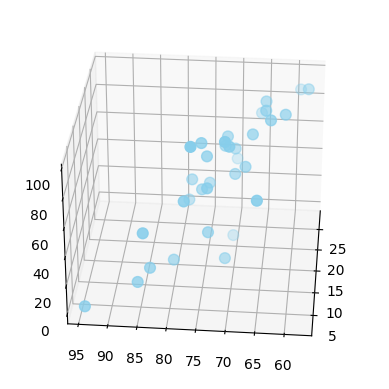

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['ocupados_industria'], train['ocupados_servicios'], train['porcen_desp'], c='skyblue', s=60)
ax.view_init(30, 185)
plt.show()

#1. Parametrización

Existen diferentes parámetros que se pueden optimizar para la utilización de RandomForests,  en este caso vamos a ceñirnos a a optimizar el número de estimadores que vamos a probar con distintas potencias de 2


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cv = TimeSeriesSplit() #

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators,
                  criterion='squared_error', random_state=0)
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['porcen_desp'], axis=1),
                           y = f_train['porcen_desp'])
      y_pred = regressor.predict(X = f_test.drop(['porcen_desp'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['porcen_desp'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')
plt.legend()
plt.show()

NameError: name 'train' is not defined

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

# 2. Construcción y ejecución del modelo



Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente

In [ ]:
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='squared_error',
                                   random_state=0)

regressor.fit( X = train.drop(['porcen_desp'], axis=1), y = train['porcen_desp'])
y_pred = regressor.predict(X = test.drop(['porcen_desp'], axis = 1))

Calculamos el mae obtenido. Cuando se trata de una competición esta línea la ejecuta la propia competición

In [ ]:
mae = mean_absolute_error(test['porcen_desp'], y_pred)
print ('MAE', mae)

MAE 17.97309027777778


Y guardamos el fichero de resultados en nuestro disco.

In [ ]:
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
output = pd.DataFrame({ 'date': test.index, 'result': res})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

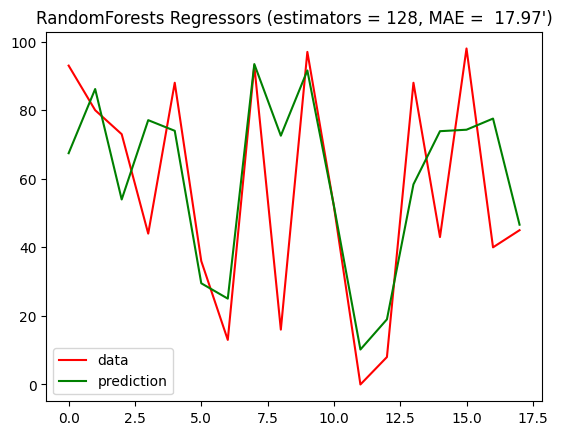

In [ ]:
from sklearn.metrics import mean_absolute_error

import numpy as np
xx = np.stack(list(i for i in range(test['porcen_desp'].shape[0])))
plt.plot(xx, test['porcen_desp'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()

In [ ]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('ipc_vivi', 'asexos_tparo') ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevancies


Attributes  Decision Tree
0      ipc_vivi       0.312344
1  asexos_tparo       0.687656

## Boosting

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=6, criterion='squared_error'))
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=6,
                                    criterion='squared_error'),
                          n_estimators=128, random_state=0))
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
regressors.append(GradientBoostingRegressor(n_estimators=50, learning_rate=0.25,
                                            random_state=0, loss='squared_error'))

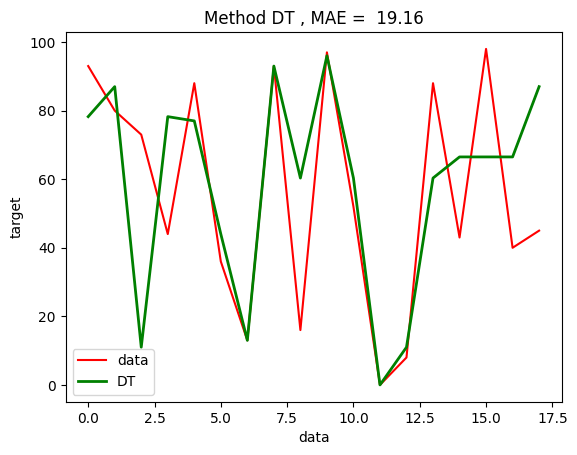

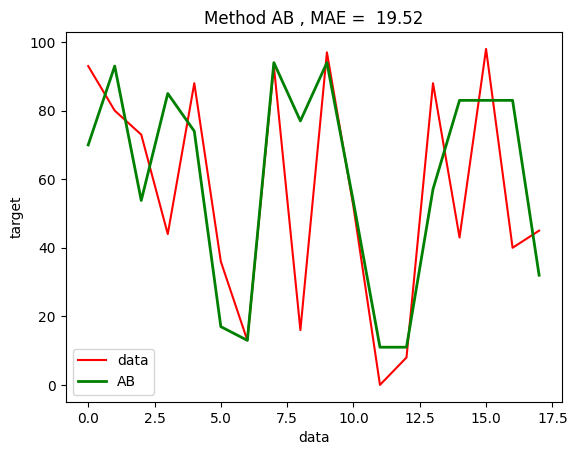

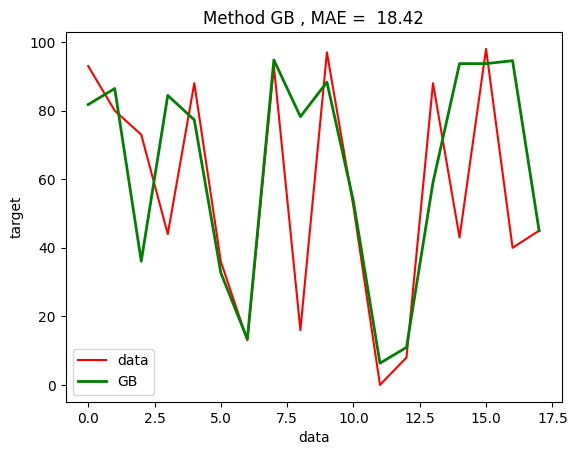

In [ ]:
xx = np.stack(list(i for i in range(test['porcen_desp'].shape[0])))
regr_names = ["DT", "AB", "GB"]

results = pd.DataFrame()
results['real'] = test['porcen_desp']

for i, r in enumerate(regressors):
    r.fit( X = train.drop(['porcen_desp'], axis=1), y = train['porcen_desp'])
    y = r.predict(X = test.drop(['porcen_desp'], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(test['porcen_desp'],y)
    # Plot the results
    plt.figure()
    plt.plot(xx, test['porcen_desp'], c='r', label='data')
    plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Method %s , MAE = %6.2f" % (regr_names[i], mae ))
    plt.axis('tight')
    plt.legend()
    plt.show()

In [ ]:
from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>